In [1]:
import os

from os.path import exists
import time
import calendar
from scipy.interpolate import make_interp_spline, BSpline
import sys
import numpy as np
import pandas as pd
import warnings
from datetime import date, datetime
import statsmodels.api as sm
from IPython.core.display import display, HTML
from IPython.display import clear_output
import snowflake.connector 
import matplotlib.pyplot as plt
from pandas.tseries.offsets import Week
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.ticker as mtick

warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 550)
pd.set_option('display.max_columns', 550)
import snowflake.connector
cnx = snowflake.connector.connect(
    user='nmittleman@toasttab.com',
    account='toast.us-east-1',
    authenticator='externalbrowser'
    )

%matplotlib inline

def QueryDWH(query, cnx, col=[]):
    cur = cnx.cursor()
    cur.execute(query)
    # If there is no col input, then get the columns from the return of the
    # snowflake query
    if not col:
        df = pd.DataFrame(cur.fetchall())
        if not df.empty:
            df.columns = [desc[0] for desc in cur.description]
    else:
        df = pd.DataFrame(cur.fetchall(), columns=col)

    return df
QueryDWH("""USE DATABASE TOAST""", cnx)
QueryDWH("""USE WAREHOUSE TOAST_WH""", cnx)


C:\Users\Toast User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Toast User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Toast User\anaconda3\lib\site-packages\snowflake\connector\options.py:94: UserWarning: You have an incompatible version of 'pyarrow' installed (0.16.0), please install a version that adheres to: 'pyarrow<3.1.0,>=3.0.0; extra == "pandas"'
  warn_incompatible_dep(


,status
0,Statement executed successfully.


In [2]:
query = """
        SELECT DATE_TRUNC('Month', pos_first_order_Date)
             , restaurant_type
             , restaurant_service_model
             , opportunity_close_date
        FROM analytics_core.customer
        """
dfRaw = QueryDWH(query, cnx, ['FOD', 'Type', 'Model', 'Booking'])
dfRaw['FOD'] = pd.to_datetime(dfRaw['FOD']).dt.date
dfRaw['Booking'] = pd.to_datetime(dfRaw['Booking']).dt.date

In [89]:
class PlotParams:
    # A Class that defines the plot characteristics
    # Plot characteristics are any attributes that define 
    # what type of plot, line colors, styles or smoothing
    
    def __init__(self, plotStyle = 'Line', fig=None, ax=None, grid=False, linestyle = '-', colorlist = None, k = 1):
        from matplotlib import lines    
        from matplotlib.colors import is_color_like

        
        # Line Style
        if plotStyle in ['Line', 'Scatter']:
            self._plotStyle = plotStyle
        else:
            raise Exception("plotStyle must be one of: 'Line', 'Scatter'")
        
        # Grid
        if type(grid) == bool:
            self._grid = grid
        else:
            raise Exception("grid must be of Type Bool")
            
        # linestyle
        
        if (linestyle in lines.lineStyles.keys()) :
            self._linestyle = linestyle
        else:
            raise Exception(f"linestyle must be one of: {lines.lineStyles.keys()}")

        # Color List
        if colorlist is None:
             self._colorlist = ['r', 'b', 'g', 'c', 'orange', 'y', 'brown', 'grey', 'pink']
        # check to makesure the values are valid
        else:
            if type(colorlist) != list:
                raise Exception(f"colorList must be of Type List or else None")
            for color in colorlist:
                if type(color) == str:
                    colorTest = is_color_like(color) | self.is_hex_color(color)
                else:
                    colorTest = False
                if colorTest == False:
                    raise Exception(f"{color} Is Not a Valid Color")
            self._colorlist = colorlist

            
        # Fig and Ax
        if (fig is None) & (ax is None):
            self._fig, self._ax = plt.subplots(figsize=(20,10))
            plt.close(fig)
        elif ((fig is not None) + (ax is not None)) == 2:
            self._fig = fig
            self._ax = ax
        else:
            raise Exception("Need to Input both 'ax' and 'fig' parameters or neither, but cannot input one and not the other")            
            
        if self._plotStyle == 'Scatter':
            self._k = 1
        else:
            self._k = k
        
        self._colorCounter = 0

    def is_hex_color(self, input_string):
        import re
        HEX_COLOR_REGEX = r'^#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})$'        
        regexp = re.compile(HEX_COLOR_REGEX)
        if regexp.search(input_string):
            return True
        return False
    
    def reset_color_counter(self):
        self._colorCounter = 0
        
    def increment_color_counter(self):
        self._colorCounter += 1  
        self._colorCounter = self._colorCounter % len(self._colorlist)
        
    def get_next_color(self):
        next_color = self._colorlist[self._colorCounter]
        self.increment_color_counter()
        return next_color
        
class AxisParams:
    # Definition of parameters of a plot's axis
    def __init__(self, title = '', axisFormat = None, rotation = 0, spacing = 'smart', fontsize = 14, color = 'k'):
        self._title = title
        self._format = axisFormat
        self._rotation = rotation
        self._spacing = spacing
        self._fontsize = fontsize
        self._color = color
        
class TitleParams:
    # Definition of parameters of a plot's title
    def __init__(self, title = '', fontsize = 14, color='k'):
        self._title = title
        self._fontsize = fontsize
        self._color = color

        
class LegendParams:
    # Definition of parameters of a plot's legend
    def __init__(self, show = True, location = 'best', size=30):
        self._show = show # A boolean. True means display legend, false does not
        self._location = location # The location of the legend
        self._size = size # Size of the legend text


In [90]:
def GetSmoothedSeries(index, data, k ):
        if k == 1:
            return index, data
            
        else:
            xNew = np.linspace(index.min(), index.max(), len(index)*20 - 19)
        if len(index) < 4:
            return xNew, yNew

        tmpSpl = make_interp_spline(index, data, k=k)

        yNew = tmpSpl(xNew)    
        
        return xNew, yNew

In [98]:
def FormatPlot(ax, xAxisParams, yAxisParams, titleParams, maxAxis, xAxis):
                
    xAxisList = maxAxis[xAxis]
    xAxisInd = maxAxis['index']
    
    if xAxisParams._format == 'i':
        xAxisList = xAxisList.astype(int)
    elif xAxisParams._format:
        xAxisList = pd.to_datetime(xAxisList).dt.strftime(xAxisParams._format)           
    
    if xAxisParams._spacing == 'smart':
        spacing = int(np.ceil(len(xAxisList.to_numpy()) / 6))
    else:
        spacing = xAxisParams._spacing
    
    
    ax.set_xticks(xAxisInd.to_numpy()[::spacing])
    ax.set_xticklabels(xAxisList.to_numpy()[::spacing])

    if yAxisParams._format == '%':
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    elif yAxisParams._format == '$':
        ax.yaxis.set_major_formatter('${x:1.0f}')   
    elif yAxisParams._format == '2$':
        ax.yaxis.set_major_formatter('${x:1.2f}') 

    ax.tick_params(axis='x', labelsize=24, rotation=xAxisParams._rotation, colors=xAxisParams._color)
    ax.tick_params(axis='y', labelsize=24, colors=yAxisParams._color)

    ax.set_xlabel(xAxisParams._title, fontsize=xAxisParams._fontsize, color=xAxisParams._color)
    ax.set_ylabel(yAxisParams._title, fontsize=yAxisParams._fontsize, color=yAxisParams._color)
    ax.set_title(titleParams._title, fontsize=titleParams._fontsize, color=titleParams._color)    

In [99]:
def GetPlotStyleParameters(col, key, numGroups, numCols, plotParams,  colorCounter):
    if numGroups == 1:
        label = f'{col}'
    elif numCols == 1:
        label = f'{key}'
    else:
        label = f'{key} - {col}'

    color = plotParams.get_next_color()

    if key == 'Total':
        color = 'k'

    if key == 'Total':
        linestyle = '--'
    else:
        linestyle = plotParams._linestyle                



    return color, linestyle, label, colorCounter

In [100]:
def PlotSmoothLine(df, xAxis, colList, 
                   group = None, 
                   plotParams = None,
                   xAxisParams = None,
                   yAxisParams = None,
                   legendParams = None,
                   titleParams = None,
                   smoothing = True, 
                   savefig = None, showPlot=True, verbose = False):
    
    # Initializing Inputs
    if not plotParams:
        plotParams = PlotParams()
    fig = plotParams._fig
    ax = plotParams._ax
    
    if not titleParams:
        titleParams = TitleParams()
    
    if not xAxisParams:
        xAxisParams = AxisParams()
        
    if not yAxisParams:
        yAxisParams = AxisParams()
    
    if not legendParams:
        legendParams = LegendParams()
   
    if group is None:
        group = '__temp_group'
        df[group] = 'A'
    
    # If the column input is a column name - turn it into a list
    if type(colList) == str:
        colList = [colList]
    numCols = len(colList)    
    numGroups = df[group].nunique()
    
    # Create a master axis which has all of the axis points for each grouping
    maxAxis = pd.DataFrame(df[xAxis].unique(), columns = [xAxis])
    maxAxis.reset_index(inplace=True)
    
    colorCounter = 0
    grpbyObj = df.groupby([group])
    
    # Iterate through each col in the col list and each group in the grouping and plot that
    for col in colList:
        for key, grp in grpbyObj:
            
            # Ensure that the axes always align - this is done by merging the data to the maxAxis
            # any nulls are forward fills and any leading nulls are zeroed
            grp = maxAxis.merge(grp, how='left')
            grp[group] = key
            grp[col].fillna(method='ffill', inplace=True)
            grp[col].fillna(0, inplace=True)
            grp = grp.reset_index(drop=True).reset_index()

            # if k = 1 (no smoothing, then the axes and data points remain as they are)
            if plotParams._k == 1:
                xNew = grp['index']
                yNew = grp[col]
            else:
                # if there is smoothing - create the new smoothed data points
                xNew, yNew = GetSmoothedSeries(grp['index'], grp[col], plotParams._k )
            
            # Get the plot / line attributes
            color, linestyle, label, colorCounter = GetPlotStyleParameters(col, key, numGroups, numCols, plotParams, colorCounter)
            
            #
            if plotParams._plotStyle == 'Line':
                ax.plot(xNew, yNew, label = label, c=color, linestyle=linestyle)
            elif plotParams._plotStyle == 'Scatter':     
                ax.scatter(xNew, yNew, label = label, c=color)

    FormatPlot(ax, xAxisParams, yAxisParams, titleParams, maxAxis,xAxis)

    if plotParams._grid:
        ax.grid()

    if legendParams._show:
        ax.legend(loc=legendParams._location, prop={'size': legendParams._size})

    if savefig:
        plt.savefig(f'{savefig}.png', bbox_inches='tight')

    if showPlot:
        display(fig)

    return fig, ax

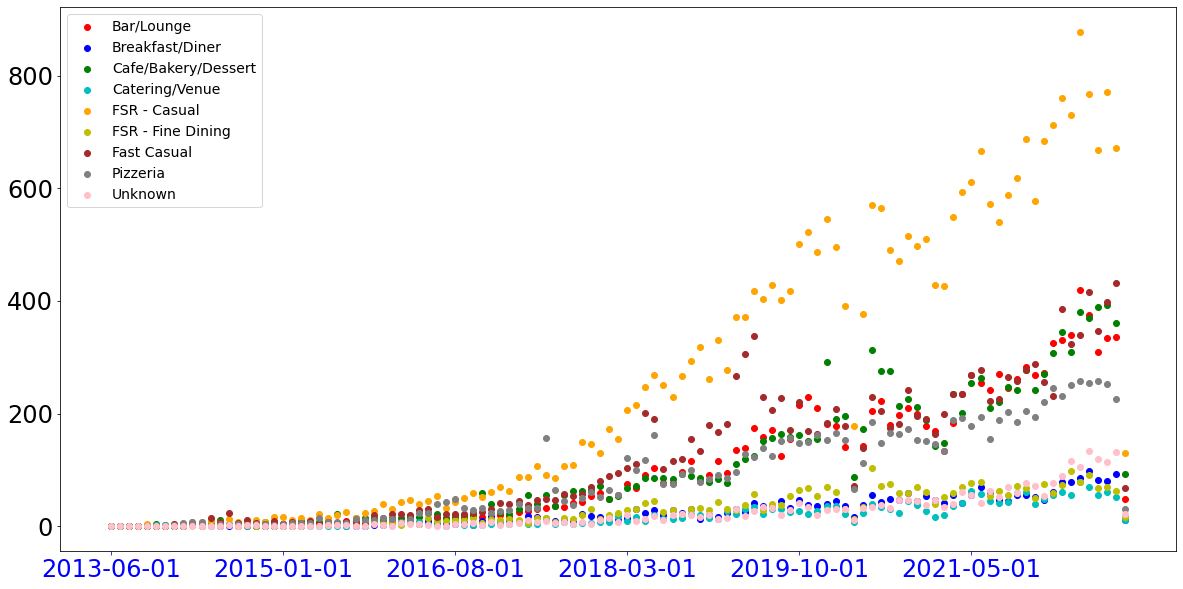

In [111]:
plotParams = PlotParams(k=1, plotStyle = 'Scatter')
legendParams = LegendParams(size=14)
xAxisParams = AxisParams(color='b')
dfRaw['Ct'] = 1
df = dfRaw.groupby(['FOD', 'Type'])[['Ct']].sum().reset_index()
# df = df[df['FOD'] > date(2021,1,1)]
# df.reset_index(inplace=True)
# df.rename(columns = {'index': 'axis'}, inplace=True)
fig, ax = PlotSmoothLine(df, 'FOD', ['Ct'], group = 'Type',showPlot=True, plotParams = plotParams, xAxisParams = xAxisParams, legendParams = legendParams)